# Build Ensamble

In [34]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import sqlalchemy as sa
import pyodbc
import warnings
import urllib
warnings.filterwarnings('ignore')

path = "./Classes"
os.chdir(path)

from HYPERTUNNER import ModelOptimizer
from DATAPREPROCESSOR import DataPreprocessor
from MODEL_FEATURE_EVALUATOR import ModelEvaluator ,FeatureImportance


iterations = 200




################### GET PAYMENT DATA ##########################

path = "../../1. Data/Cleaned Transaction Data"
os.chdir(path)


df = pd.read_excel('PreeProcessed_Psd2.xlsx')
#df = df.drop(columns=['ReceivedDate','AccountNumber','ApplicationID','SSN','DisbursedDate','Amount','IsMainApplicant','ApplicantNo','NR','_merge','HasCoapp'])


import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, roc_auc_score, roc_curve
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt


# Custom Gini coefficient scorer
def gini_scorer(y_true, y_pred):
    auc = roc_auc_score(y_true, y_pred)
    return 2 * auc - 1

# Ensure the custom scorer is correctly created
gini_score = make_scorer(gini_scorer, needs_proba=True, greater_is_better=True)



# Function to plot Gini coefficient
def plot_gini(model, X_train, y_train, X_val, y_val, X_test, y_test, title):
    y_train_pred_proba = model.predict_proba(X_train)[:, 1]
    y_val_pred_proba = model.predict_proba(X_val)[:, 1]
    y_test_pred_proba = model.predict_proba(X_test)[:, 1]

    gini_train = gini_scorer(y_train, y_train_pred_proba)
    gini_val = gini_scorer(y_val, y_val_pred_proba)
    gini_test = gini_scorer(y_test, y_test_pred_proba)
    
    auc_train = (gini_train + 1) / 2  # Convert Gini to AUC
    auc_val = (gini_val + 1) / 2  # Convert Gini to AUC
    auc_test = (gini_test + 1) / 2  # Convert Gini to AUC

    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
    fpr_val, tpr_val, _ = roc_curve(y_val, y_val_pred_proba)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

    plt.figure()
    plt.plot(fpr_train, tpr_train, label=f'Training ROC curve (AUC = {auc_train:.2f}, Gini = {gini_train:.2f})')
    plt.plot(fpr_val, tpr_val, label=f'Validation ROC curve (AUC = {auc_val:.2f}, Gini = {gini_val:.2f})')
    plt.plot(fpr_test, tpr_test, label=f'Test ROC curve (AUC = {auc_test:.2f}, Gini = {gini_test:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")

    plt.show()

    return np.concatenate([y_train_pred_proba, y_val_pred_proba, y_test_pred_proba])


import matplotlib.pyplot as plt
import numpy as np

# Assuming train_upsampled_re and test_re dataframes are already loaded


def plotScoreDist(train_upsampled_re,val_re,test_re,feature):
    # Create masks for each category
    category1_train = train_upsampled_re[train_upsampled_re['Ever90'] == 0]
    category2_train = train_upsampled_re[train_upsampled_re['Ever90'] == 1]
    category1_val = val_re[val_re['Ever90'] == 0]
    category2_val = val_re[val_re['Ever90'] == 1]
    category1_test = test_re[test_re['Ever90'] == 0]
    category2_test = test_re[test_re['Ever90'] == 1]

    # Create a figure and axis
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))  # 1 row, 2 columns

    # Plot histograms for train data
    axs[0].hist(category1_train[feature], bins=30, edgecolor='k', alpha=0.5, label='Ever90 = 0', density=True)
    axs[0].hist(category2_train[feature], bins=30, edgecolor='k', alpha=0.5, label='Ever90 = 1', density=True)
    axs[0].set_title('Train Default Probabilities Hist')
    axs[0].set_xlabel('Probability of Default')
    axs[0].set_ylabel('Density')
    axs[0].legend(loc='upper right')
    axs[0].grid(True, which='both', linestyle='--', linewidth=0.5)

    # Plot histograms for test data
    axs[1].hist(category1_val[feature], bins=30, edgecolor='k', alpha=0.5, label='Ever90 = 0', density=True)
    axs[1].hist(category2_val[feature], bins=30, edgecolor='k', alpha=0.5, label='Ever90 = 1', density=True)
    axs[1].set_title('Validation Default Probabilities Hist')
    axs[1].set_xlabel('Probability of Default')
    axs[1].set_ylabel('Density')
    axs[1].legend(loc='upper right')
    axs[1].grid(True, which='both', linestyle='--', linewidth=0.5)

    # Plot histograms for test data
    axs[2].hist(category1_test[feature], bins=30, edgecolor='k', alpha=0.5, label='Ever90 = 0', density=True)
    axs[2].hist(category2_test[feature], bins=30, edgecolor='k', alpha=0.5, label='Ever90 = 1', density=True)
    axs[2].set_title('Test Default Probabilities Hist')
    axs[2].set_xlabel('Probability of Default')
    axs[2].set_ylabel('Density')
    axs[2].legend(loc='upper right')
    axs[2].grid(True, which='both', linestyle='--', linewidth=0.5)

    # Show the plot
    plt.tight_layout()
    plt.show()

    #print(f"Mean Probability for Train Data: {np.mean(train_upsampled_re[feature])}")
    #print(f"Mean Probability for Test Data: {np.mean(test_re[feature])}")



def LevelOneScore(model , train,val, test ,df, optimal_features ,plot = True):

    forforsta = df[['Ever90']+list(optimal_features)]

    # Assume preprocessor, DataPreprocessor, base, gini_scorer are predefined
    preprocessor = DataPreprocessor(forforsta)

    ## Scalle
    (Xtrain, Ytrain),(Xval, Yval),  (Xtest, Ytest) = preprocessor.scaller(train,val, test, features =  list(optimal_features))

    y_train_pred_proba = model.predict_proba(Xtrain)[:, 1]
    y_val_pred_proba = model.predict_proba(Xval)[:, 1]
    y_test_pred_proba = model.predict_proba(Xtest)[:, 1]

    # Plot for both the training and validation sets
    if plot == True:
        plot_gini(model, Xtrain, Ytrain, Xval, Yval, Xtest, Ytest, "ROC Curve with Gini Coefficient")


    return np.concatenate([y_train_pred_proba, y_val_pred_proba, y_test_pred_proba])



FileNotFoundError: [Errno 2] No such file or directory: './Classes'

In [2]:
import os
import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from imblearn.over_sampling import RandomOverSampler
import xgboost as xgb
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, roc_auc_score, roc_curve
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
# Assuming `df`, `preprocessor`, `train`, `val`, `test`, `gini_score`, and `plot_gini` are predefined




# Reading the train.csv file into a DataFrame
train = pd.read_csv('train.csv')

# Reading the train.csv file into a DataFrame
val = pd.read_csv('val.csv')

# Reading the test.csv file into a DataFrame
test = pd.read_csv('test.csv')

df = pd.concat([train,val,test])

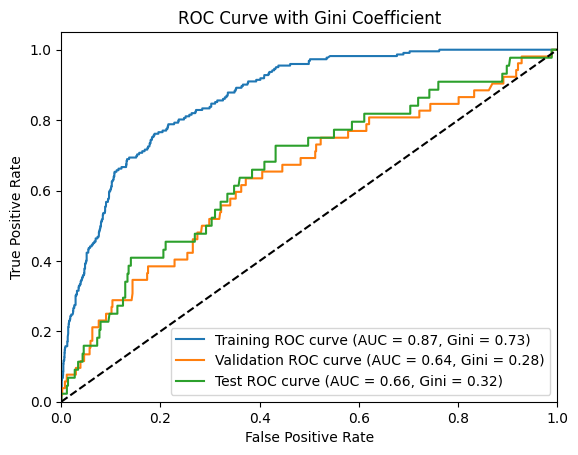

array(['avg_Loan', 'avg_Salary', 'avg3Months_CashWithdrawal',
       'avg3Months_Deposit', 'avg3Months_Loan', 'avg6Months_Loan',
       'avg6Months_MobilePayment', 'avg6Months_Salary',
       'count_InstallmentPayment', 'count_Loan', 'sum_Salary',
       'trend_Gaming', 'trend_MobilePayment', 'Gambling_monthlyAvg',
       'CashWithdrawal_sum12Months', 'CashWithdrawal_sum6Months',
       'CashWithdrawal_sum9Months', 'Gaming_count3Months',
       'MobilePayment_partOfSalary3Months',
       'MobilePayment_partOfSalary6Months',
       'DebtCollection_partOfSalary9Months', 'DebtCollection_sum12Months',
       'InstallmentPayment_count12Months',
       'InstallmentPayment_monthlyAvg',
       'InstallmentPayment_partOfSalary12Months',
       'HousingCost_count6Months', 'HousingCost_partOfSalary3Months',
       'DirectDebit_sum12Months', 'Unclassified_count12Months',
       'Unclassified_sum3Months'], dtype='<U39')

In [4]:
# Change the directory to the specified path
path = "../../2. Python/Finished Models"
os.chdir(path)

# Load the model and optimal features
xgb_model = joblib.load('xgb_model_1.pkl')
xgb_optimal_features = joblib.load('optimal_featuresxgb_model_1.pkl')

xgb_score = LevelOneScore(xgb_model , train,val, test ,df, xgb_optimal_features,plot = True)

xgb_optimal_features

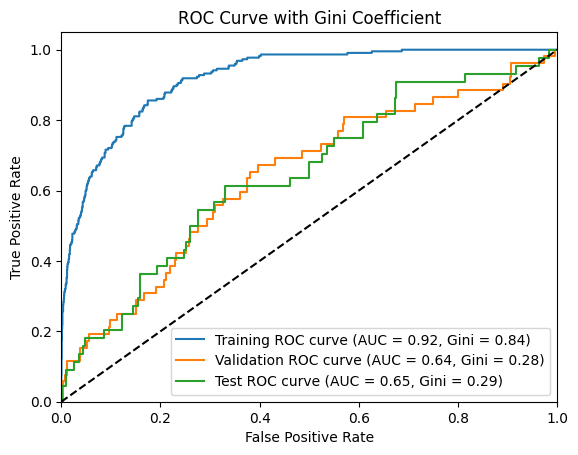

array(['avg6Months_Loan', 'avg_Loan', 'sum_Loan',
       'Unclassified_sum3Months', 'count_Loan', 'avg6Months_Salary',
       'avg_Salary', 'sum installmentPayments', 'avg3Months_Loan',
       'avg3Months_CashWithdrawal', 'DebtCollection_sum3Months',
       'avg6Months_CashWithdrawal', 'trend_Gaming', 'avg3Months_Deposit',
       'Gambling_sum9Months', 'InstallmentPayment_partOfSalary3Months',
       'trend_DebtCollection', 'DebtCollection_sum12Months',
       'CashWithdrawal_sum6Months', 'Gaming_count3Months',
       'trend_Deposit', 'CashWithdrawal_partOfSalary9Months',
       'count_MobilePayment', 'InstallmentPayment_partOfSalary6Months',
       'DebtCollection_sum9Months', 'sum_Gambling', 'avg_Gambling',
       'sum_Salary', 'trend_Salary', 'Gaming_partOfSalary12Months',
       'CashWithdrawal_partOfSalary3Months', 'Gaming_count6Months',
       'avg3Months_MobilePayment', 'MobilePayment_count12Months',
       'HousingCost_category', 'MobilePayment_partOfSalary6Months'],
      dtyp

In [5]:


# Load the model and optimal features
rf_model = joblib.load('rf_model_1.pkl')
rf_optimal_features = joblib.load('optimal_features_rf_model_1.pkl')

rf_score =  LevelOneScore(rf_model , train,val, test ,df, rf_optimal_features)

rf_optimal_features


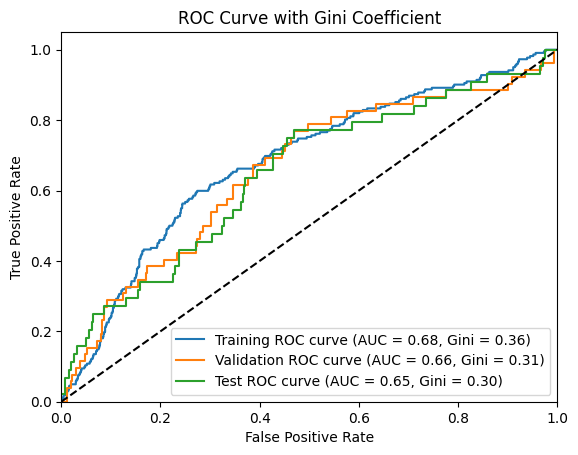

array(['avg_Gambling', 'avg_Loan', 'avg_Salary', 'avg3Months_Loan',
       'avg6Months_Gambling', 'avg6Months_Loan', 'avg6Months_Salary',
       'count_Loan', 'count_PassiveIncome', 'sum_OtherIncome',
       'sum_Salary', 'trend_DebtCollection', 'trend_Gaming',
       'trend_MobilePayment', 'trend_Salary',
       'CashWithdrawal_count6Months', 'CashWithdrawal_sum12Months',
       'Gaming_count3Months', 'MobilePayment_count12Months',
       'DebtCollection_sum12Months', 'DebtCollection_sum3Months',
       'InstallmentPayment_count12Months'], dtype='<U34')

In [6]:


# Load the model and optimal features
lg_model = joblib.load('lg_model_1.pkl')
lg_optimal_features = joblib.load('optimal_features_lg_model_1.pkl')

lg_score =  LevelOneScore(lg_model , train,val, test ,df, lg_optimal_features)

lg_optimal_features


## Controll - From the best RF where all data was included and no amipulation on main/co


In [7]:
scores = df[['Ever90','ApplicationID','HasCoapp']]

scores['lg_score'] = lg_score
scores['rf_score'] = rf_score
scores['xgb_score'] = xgb_score




In [8]:


486

486

In [9]:

## Divide in to data splits again
train = scores.iloc[:len(train)]


val = scores.iloc[len(train):len(val)+len(train)]


test = scores.iloc[len(val)+len(train):]



In [10]:
#lg_score	rf_score	xgb_score

input = scores[['Ever90'] +['lg_score','rf_score',	'xgb_score'] ]


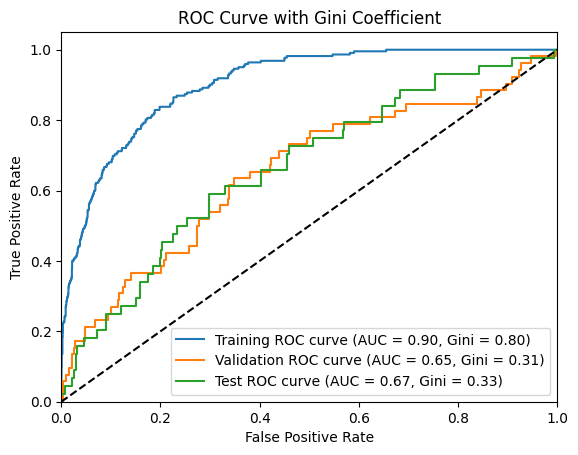

['lg_score', 'rf_score', 'xgb_score']

In [11]:

# Load the model and optimal features
nb2_model = joblib.load('naive_bayes_model_2.pkl')
nb2_optimal_features = ['lg_score','rf_score',	'xgb_score'] ## joblib.load('optimal_features_naive_bayes_model_2.pkl')   ## blev fler i sorteringen 

nb2_score =  LevelOneScore(nb2_model , train,val, test ,input, nb2_optimal_features)

nb2_optimal_features


In [12]:




input['Combo_2NB'] =  nb2_score
input['ApplicationID'] = df.ApplicationID
input

,Ever90,lg_score,rf_score,xgb_score,Combo_2NB,ApplicationID
0,0,0.701898,0.412130,0.533706,0.436198,8513891
1,0,0.425501,0.376075,0.375010,0.004023,8528123
2,0,0.525376,0.510928,0.520986,0.677534,8621901
3,0,0.461448,0.417763,0.478537,0.091803,8201314
4,0,0.477137,0.331904,0.404928,0.003393,8420404
...,...,...,...,...,...,...
481,0,0.565388,0.454165,0.442422,0.167366,8409647
482,0,0.459982,0.533501,0.406000,0.218854,8614945
483,0,0.443630,0.393675,0.442698,0.026505,8370396
484,0,0.396953,0.310770,0.305119,0.000132,8649594


## Final

In [13]:
import pandas as pd

# Assuming 'input' is your original DataFrame
df_predictions = input.copy()

# Group by 'ApplicationID' and get the minimum 'xgb_score' for each account
min_probabilities = df_predictions.groupby('ApplicationID')['Combo_2NB'].min().reset_index()
min_probabilities.rename(columns={'Combo_2NB': 'min_Combo_2NB_score'}, inplace=True)

# Group by 'ApplicationID' and get the maximum 'xgb_score' for each account
max_probabilities = df_predictions.groupby('ApplicationID')['Combo_2NB'].max().reset_index()
max_probabilities.rename(columns={'Combo_2NB': 'max_Combo_2NB_score'}, inplace=True)

# Merge the original DataFrame with min and max probabilities
df_merged = df_predictions.merge(min_probabilities, on='ApplicationID')
df_merged = df_merged.merge(max_probabilities, on='ApplicationID')

# If you want to drop duplicates based on specific columns (e.g., 'ApplicationID'), you can do:
df_merged.drop_duplicates(subset=['ApplicationID'], inplace=True)

df_merged

,Ever90,lg_score,rf_score,xgb_score,Combo_2NB,ApplicationID,min_Combo_2NB_score,max_Combo_2NB_score
0,0,0.701898,0.412130,0.533706,0.436198,8513891,0.436198,0.983745
1,0,0.425501,0.376075,0.375010,0.004023,8528123,0.004023,0.985985
2,0,0.525376,0.510928,0.520986,0.677534,8621901,0.000047,0.677534
3,0,0.461448,0.417763,0.478537,0.091803,8201314,0.000506,0.091803
4,0,0.477137,0.331904,0.404928,0.003393,8420404,0.003393,0.003393
...,...,...,...,...,...,...,...,...
3447,0,0.371856,0.264083,0.445917,0.000732,8466300,0.000732,0.000732
3448,0,0.565388,0.454165,0.442422,0.167366,8409647,0.167366,0.167366
3449,0,0.459982,0.533501,0.406000,0.218854,8614945,0.218854,0.218854
3450,0,0.443630,0.393675,0.442698,0.026505,8370396,0.026505,0.026505


In [14]:

#tsm = df_merged

include_coapp = df[['ApplicationID','HasCoapp']].drop_duplicates()

df_merged = df_merged[['Ever90','ApplicationID','min_Combo_2NB_score','max_Combo_2NB_score']]

tsm =pd.merge(df_merged,include_coapp ,on='ApplicationID')

tsm['max_Combo_2NB_score'] = np.where(tsm.HasCoapp == 1 ,tsm['max_Combo_2NB_score'] ,np.mean(tsm[tsm.HasCoapp == 1].max_Combo_2NB_score) )

tsm_train = pd.merge(tsm, train['ApplicationID'], on='ApplicationID',how='right').drop_duplicates()
tsm_val = pd.merge(tsm, val['ApplicationID'], on='ApplicationID',how='right').drop_duplicates()
tsm_test = pd.merge(tsm, test['ApplicationID'], on='ApplicationID',how='right').drop_duplicates()


In [15]:
tsm_train

,Ever90,ApplicationID,min_Combo_2NB_score,max_Combo_2NB_score,HasCoapp
0,0,8513891,4.361983e-01,9.837447e-01,1
1,0,8528123,4.022867e-03,9.859855e-01,1
2,0,8621901,4.728732e-05,6.775343e-01,1
3,0,8201314,5.060969e-04,9.180295e-02,1
4,0,8420404,3.392786e-03,2.613825e-01,0
...,...,...,...,...,...
2164,0,8516914,4.591228e-02,1.298015e-01,1
2165,0,8371422,7.045111e-09,7.045111e-09,1
2166,0,8488108,1.435458e-01,2.613825e-01,0
2167,0,8553015,1.558671e-02,2.613825e-01,0


In [16]:
import pandas as pd

# Assuming 'input' is your original DataFrame
df_predictions = input.copy()

# Group by 'ApplicationID' and get the minimum 'xgb_score' for each account
min_probabilities = df_predictions.groupby('ApplicationID')['Combo_2NB'].min().reset_index()
min_probabilities.rename(columns={'Combo_2NB': 'min_Combo_2NB_score'}, inplace=True)

# Group by 'ApplicationID' and get the maximum 'xgb_score' for each account
max_probabilities = df_predictions.groupby('ApplicationID')['Combo_2NB'].max().reset_index()
max_probabilities.rename(columns={'Combo_2NB': 'max_Combo_2NB_score'}, inplace=True)

# Merge the original DataFrame with min and max probabilities
df_merged = df_predictions.merge(min_probabilities, on='ApplicationID')
df_merged = df_merged.merge(max_probabilities, on='ApplicationID')

# If you want to drop duplicates based on specific columns (e.g., 'ApplicationID'), you can do:
df_merged.drop_duplicates(subset=['ApplicationID'], inplace=True)


#tsm = df_merged

include_coapp = df[['ApplicationID','HasCoapp']].drop_duplicates()

df_merged = df_merged[['Ever90','ApplicationID','min_Combo_2NB_score','max_Combo_2NB_score']]

tsm =pd.merge(df_merged,include_coapp ,on='ApplicationID')

tsm['max_Combo_2NB_score'] = np.where(tsm.HasCoapp == 1 ,tsm['max_Combo_2NB_score'] ,np.mean(tsm[tsm.HasCoapp == 1].max_Combo_2NB_score) )

tsm_train = pd.merge(tsm, train['ApplicationID'], on='ApplicationID',how='right').drop_duplicates()
tsm_val = pd.merge(tsm, val['ApplicationID'], on='ApplicationID',how='right').drop_duplicates()
tsm_test = pd.merge(tsm, test['ApplicationID'], on='ApplicationID',how='right').drop_duplicates()



In [17]:
tsm

,Ever90,ApplicationID,min_Combo_2NB_score,max_Combo_2NB_score,HasCoapp
0,0,8513891,0.436198,0.983745,1
1,0,8528123,0.004023,0.985985,1
2,0,8621901,0.000047,0.677534,1
3,0,8201314,0.000506,0.091803,1
4,0,8420404,0.003393,0.261382,0
...,...,...,...,...,...
2982,0,8466300,0.000732,0.000732,1
2983,0,8409647,0.167366,0.261382,0
2984,0,8614945,0.218854,0.261382,0
2985,0,8370396,0.026505,0.261382,0


In [18]:
tsm_train

,Ever90,ApplicationID,min_Combo_2NB_score,max_Combo_2NB_score,HasCoapp
0,0,8513891,4.361983e-01,9.837447e-01,1
1,0,8528123,4.022867e-03,9.859855e-01,1
2,0,8621901,4.728732e-05,6.775343e-01,1
3,0,8201314,5.060969e-04,9.180295e-02,1
4,0,8420404,3.392786e-03,2.613825e-01,0
...,...,...,...,...,...
2164,0,8516914,4.591228e-02,1.298015e-01,1
2165,0,8371422,7.045111e-09,7.045111e-09,1
2166,0,8488108,1.435458e-01,2.613825e-01,0
2167,0,8553015,1.558671e-02,2.613825e-01,0


,Ever90,ApplicationID,min_Combo_2NB_score,max_Combo_2NB_score,HasCoapp
0,0,8513891,0.436198,0.983745,1
1,0,8528123,0.004023,0.985985,1
2,0,8621901,0.000047,0.677534,1
3,0,8201314,0.000506,0.091803,1
4,0,8420404,0.003393,0.261382,0
...,...,...,...,...,...
2982,0,8466300,0.000732,0.000732,1
2983,0,8409647,0.167366,0.261382,0
2984,0,8614945,0.218854,0.261382,0
2985,0,8370396,0.026505,0.261382,0


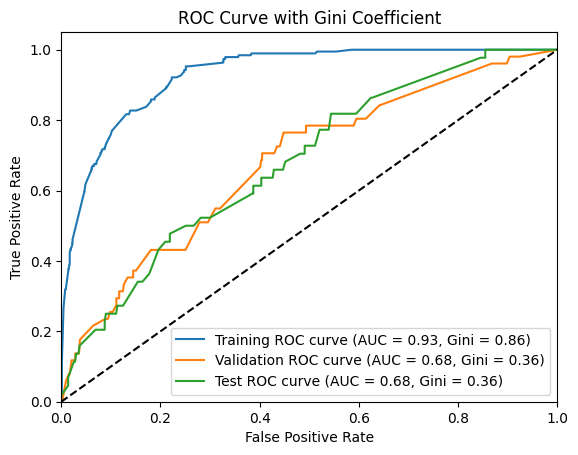

In [19]:

# Load the model and optimal features
rf3_model = joblib.load('random_forest_model_3.pkl')
rf3_optimal_features = ['min_Combo_2NB_score','max_Combo_2NB_score'] ## joblib.load('optimal_features_naive_bayes_model_2.pkl')   ## blev fler i sorteringen 

rf3_score =  LevelOneScore(rf3_model , tsm_train,  tsm_val, tsm_test ,tsm, rf3_optimal_features)


In [23]:
tsm_train

,Ever90,ApplicationID,min_Combo_2NB_score,max_Combo_2NB_score,HasCoapp
0,0,8513891,4.361983e-01,9.837447e-01,1
1,0,8528123,4.022867e-03,9.859855e-01,1
2,0,8621901,4.728732e-05,6.775343e-01,1
3,0,8201314,5.060969e-04,9.180295e-02,1
4,0,8420404,3.392786e-03,2.613825e-01,0
...,...,...,...,...,...
2164,0,8516914,4.591228e-02,1.298015e-01,1
2165,0,8371422,7.045111e-09,7.045111e-09,1
2166,0,8488108,1.435458e-01,2.613825e-01,0
2167,0,8553015,1.558671e-02,2.613825e-01,0


In [26]:
rf3_score[:len(tsm_train)]

array([0.80422559, 0.35125696, 0.12611082, ..., 0.44710878, 0.1552346 ,
       0.05903234])

In [36]:
tsm_train['3_Model'] = rf3_score[:len(tsm_train)] 
tsm_val['3_Model'] = rf3_score[:len(tsm_val)] 
tsm_test['3_Model'] = rf3_score[:len(tsm_test)] 

done = pd.concat([tsm_train,tsm_val,tsm_test])

Streategy_df = pd.concat([tsm_val,tsm_test])

done

,Ever90,ApplicationID,min_Combo_2NB_score,max_Combo_2NB_score,HasCoapp,3_Model
0,0,8513891,0.436198,0.983745,1,0.804226
1,0,8528123,0.004023,0.985985,1,0.351257
2,0,8621901,0.000047,0.677534,1,0.126111
3,0,8201314,0.000506,0.091803,1,0.000000
4,0,8420404,0.003393,0.261382,0,0.081948
...,...,...,...,...,...,...
481,0,8409647,0.167366,0.261382,0,0.823363
482,0,8614945,0.218854,0.261382,0,0.572986
483,0,8370396,0.026505,0.261382,0,0.132404
484,0,8649594,0.000132,0.882059,1,0.079310


# Strategy - Here the Train & Validation is not something that one should take strategic decision on since they have been use for problem optimisation, 

However since Val scores as high as Test (GINI) we can assue they are corresponding eachother

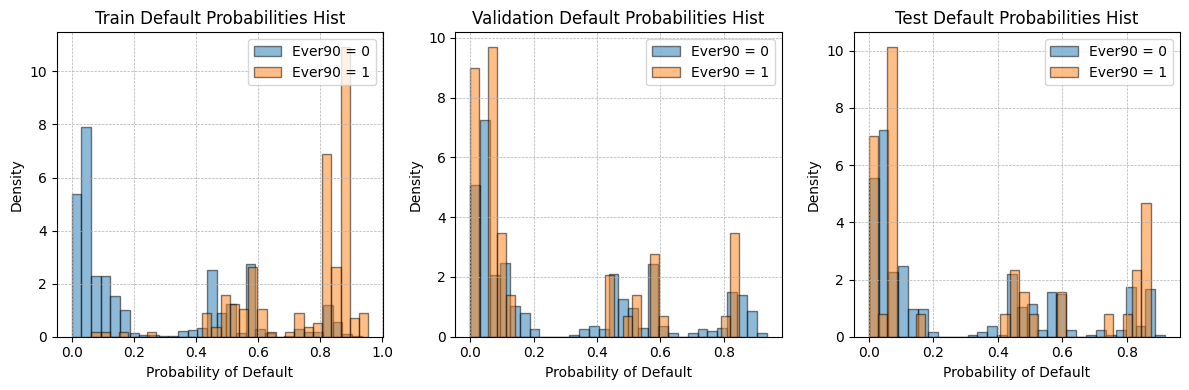

In [35]:
plotScoreDist(tsm_train,tsm_val,tsm_test,'3_Model')

In [37]:
Streategy_df

,Ever90,ApplicationID,min_Combo_2NB_score,max_Combo_2NB_score,HasCoapp,3_Model
0,1,8276367,0.000006,0.261382,0,0.804226
1,0,8455500,0.000154,0.261382,0,0.351257
2,1,8257738,0.000787,0.261382,0,0.126111
3,0,8518611,0.989364,0.261382,0,0.000000
4,0,8470473,0.000015,0.261382,0,0.081948
...,...,...,...,...,...,...
481,0,8409647,0.167366,0.261382,0,0.823363
482,0,8614945,0.218854,0.261382,0,0.572986
483,0,8370396,0.026505,0.261382,0,0.132404
484,0,8649594,0.000132,0.882059,1,0.079310


In [115]:

# Binning structure
#binsV = [0, 0.1,  0.65, 0.83,1]  

binsV = [0, 0.75,1] 

Streategy_df['Probability_Bins'] = pd.cut(Streategy_df['3_Model'], bins=binsV, labels=False)



grouped_mean = Streategy_df.groupby('Probability_Bins')[('3_Model')].mean()

# Group by Probability_Bins and Ever90, then count the number of occurrences
grouped_counts = Streategy_df.groupby(['Probability_Bins', 'Ever90']).size().unstack().reset_index()


# Replace NaN with 0 if any
grouped_counts.fillna(0, inplace=True)

# Avoid division by zero by adding a small number to the denominator
epsilon = 1e-10 
grouped_counts['90+'] = grouped_counts[1] / ((grouped_counts[0] + grouped_counts[1] +epsilon))

grouped_counts['Expected_PD'] = list(grouped_mean)



grouped_counts

Ever90,Probability_Bins,0,1,90+,Expected_PD
0,0.0,726,62,0.078680,0.233425
1,1.0,127,17,0.118056,0.841333


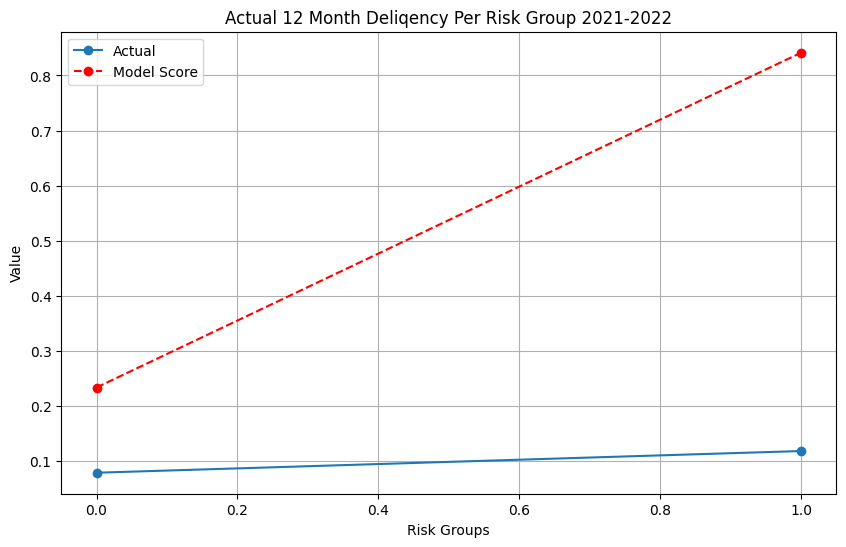

In [116]:



# Create plot
plt.figure(figsize=(10,6))
plt.plot(grouped_counts.Probability_Bins, grouped_counts['90+'], marker='o', label='Actual')
plt.plot(grouped_counts.Probability_Bins, grouped_counts.Expected_PD, marker='o', linestyle='--', color='red', label='Model Score')
plt.xlabel('Risk Groups')
plt.ylabel('Value')
plt.title('Actual 12 Month Deliqency Per Risk Group 2021-2022')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:

grouped_mean = pd_late.Streategy_df('Probability_Bins')[('Probability_model')].mean()



# Group by Probability_Bins and Ever90, then count the number of occurrences
grouped_counts = pd_late.groupby(['Probability_Bins', 'Ever90']).size().unstack().reset_index()

# Replace NaN with 0 if any
grouped_counts.fillna(0, inplace=True)

# Avoid division by zero by adding a small number to the denominator
epsilon = 1e-10 
grouped_counts['90+'] = grouped_counts[1] / ((grouped_counts[0] + grouped_counts[1] +epsilon))

grouped_counts['Expected_PD'] = list(grouped_mean)



grouped_counts['Distribution']  = (grouped_counts.iloc[:,1] + grouped_counts.iloc[:,2] ) / sum((grouped_counts.iloc[:,1] + grouped_counts.iloc[:,2] ))

grouped_counts['Amount']  = grouped_sum



grouped_counts['Count']  = grouped_counts[0] + grouped_counts[1]

grouped_counts
